In [1]:
%pylab inline
plt.rcParams['figure.figsize'] = (25, 10)

from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

import os
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree,
    plot_signal_histogram, earth_plot)
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)

# Settings

In [3]:
data_folder = Path("/home/bathiany/Sebastian/datamining/edges/obsscan")
data_set = DataSet([data_folder / 'GlobMap_V01_LAI_UHAM-ICDC_1981-2011_remapbilt250.nc'], 'lai')
# data_set = DataSet([data_folder / 'obsdata' / 'MnCldTAU.nc'], 'MnCldTAU')
# data_set = DataSet([data_folder / 'obsdata' / 'nhsce_v01r01_19661004_20180205.nc'], 'x')

## resolution: approx. 0.5 deg
sigma_d = unit('200 km')
sigma_t = unit('10 year')

gamma = 1000000
scaling_factor = gamma * unit('10 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

In [4]:
box = data_set.box

In [5]:
box.time_start

datetime.date(1980, 1, 1)

## Load the data

In [6]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(0.0307331 year, 53.1589 km, 52.95 km) per pixel
1981-07-01, 1981-07-16, 1981-08-01,  ...
time steps: max 16.0 min 2.0


In [7]:
# time mean of data
data_tm=mean(data_set.data, axis=0)

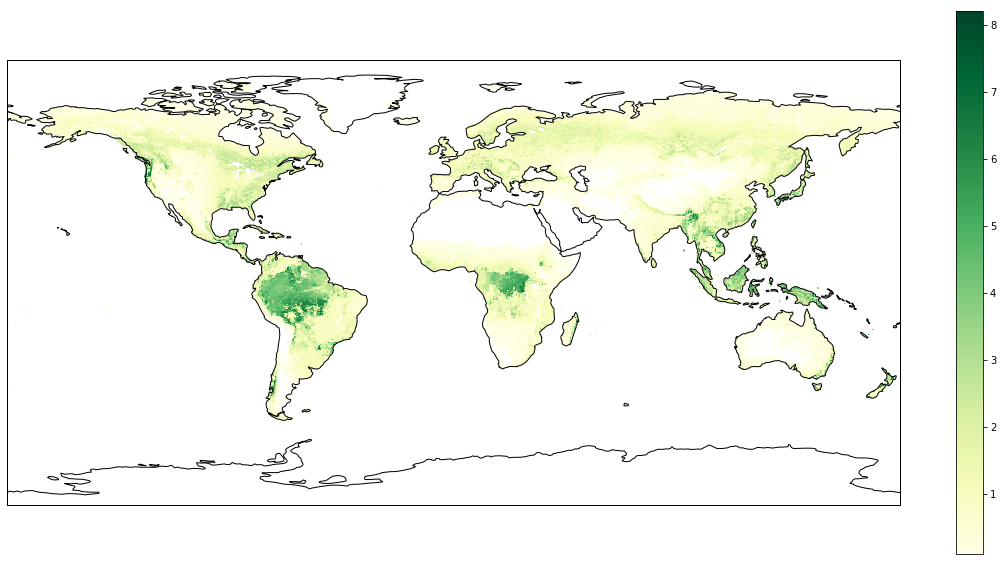

In [8]:
matplotlib.rcParams['figure.figsize'] = (25, 10)
my_cmap = matplotlib.cm.get_cmap('YlGn')
my_cmap.set_under('w')
plot_plate_carree(box, data_tm, cmap=my_cmap, vmin=0.1)


In [9]:
fig1=plot_plate_carree(box, data_tm, cmap=my_cmap, vmin=0.1)
plt.show()
plt.draw()
fig1.savefig('LAI_obs_timemean_data.png',dpi=600)

<Figure size 1800x720 with 0 Axes>

### Tapering and Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [10]:
yearly_data_set = data_set[2::12]
box = yearly_data_set.box
data = yearly_data_set.data

### minimum number of grid cells for smoothing is 3!

# resolution of this dataset is 0.5 degrees. Smoothing scale in space is 200km (approx. 2 degrees latitude).
# => typical number of grid cells for smoothing over ocean: 4 ?!


#taper_masked_area(data, [0, 5, 5], 50)
#taper_masked_area(data, [0, 3, 3], 200)

#taper_masked_area(data, [0, 5, 5], 50)
taper_masked_area(data, [0, 25, 25], 5000)
#taper_masked_area(data, [0, 5, 5], 5000)  #schlecht

smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])


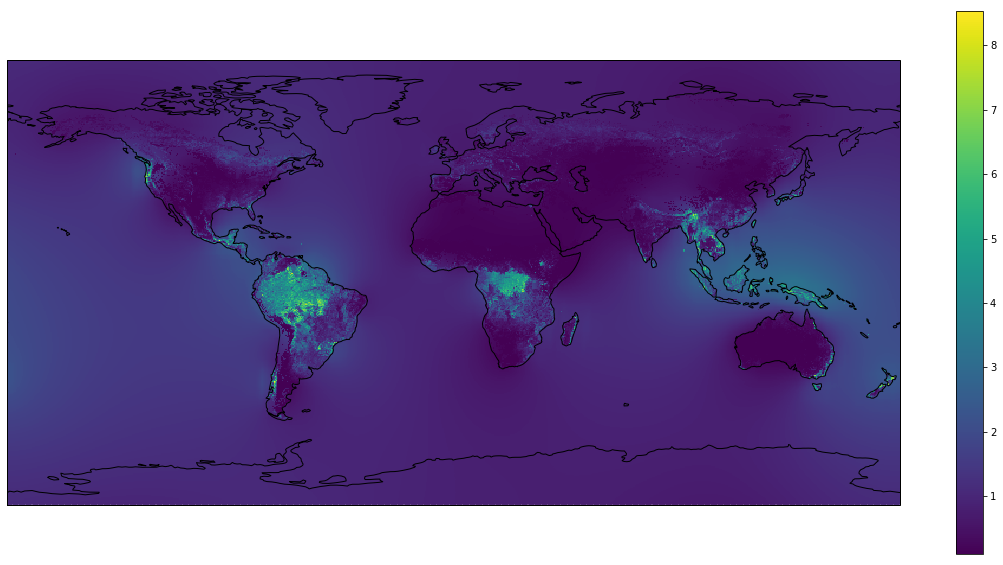

In [11]:
plot_plate_carree(box, data[1])

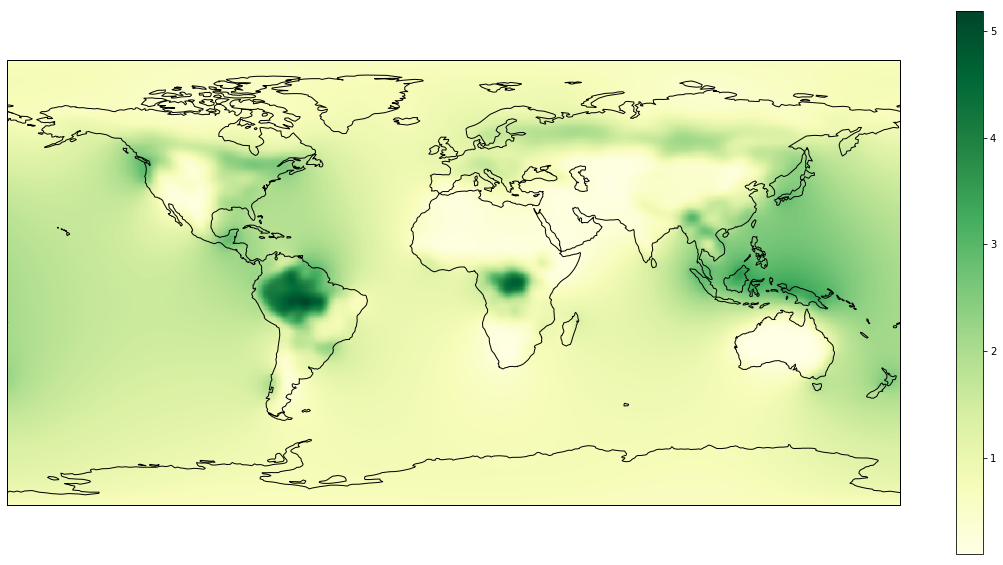

In [12]:
plot_plate_carree(box, smooth_data[0], cmap=my_cmap, vmin=0.1)


In [13]:
fig3=plot_plate_carree(box, smooth_data[0], cmap=my_cmap, vmin=0.1)
plt.show()
plt.draw()
fig3.savefig('LAI_obs_smoothed_data_initime.png',dpi=600)

<Figure size 1800x720 with 0 Axes>

### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [14]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)

### Determine proper hysteresis settings

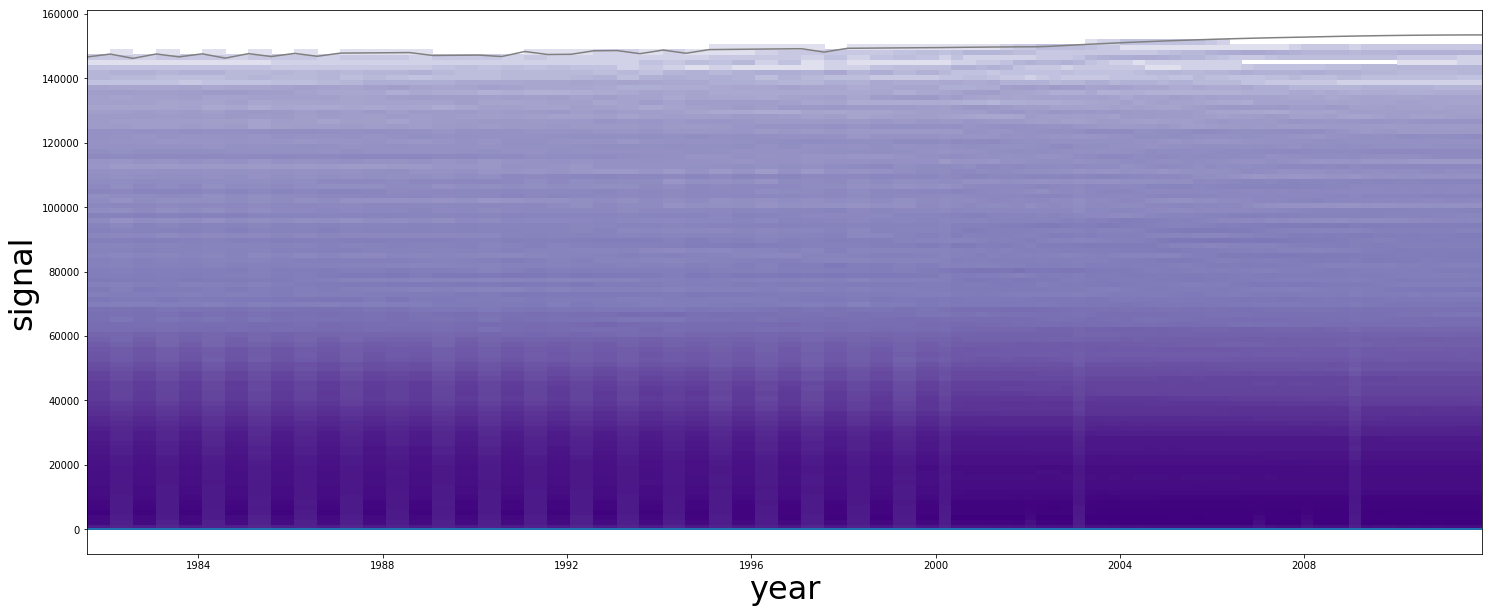

In [15]:
signal = 1/sb[3]
plot_signal_histogram(box, signal, 0.25, 0.3);

In [32]:
signalarray = np.asarray(signal).reshape(-1)
signal_no0 = np.ma.masked_equal(signalarray,0)
signal_no0=signal_no0.compressed()

upper_threshold=np.percentile(signal_no0, 75)
lower_threshold=np.percentile(signal_no0, 50)

In [33]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [34]:
# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).copy()
dat[:,:,:,3] = sb[3].transpose([2,1,0])
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy()

In [35]:
#edges = cp_double_threshold(data=dat, mask=mask, a=1/14000, b=1/13000)   #20000  10000
edges = cp_double_threshold(data=dat, mask=mask, a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])


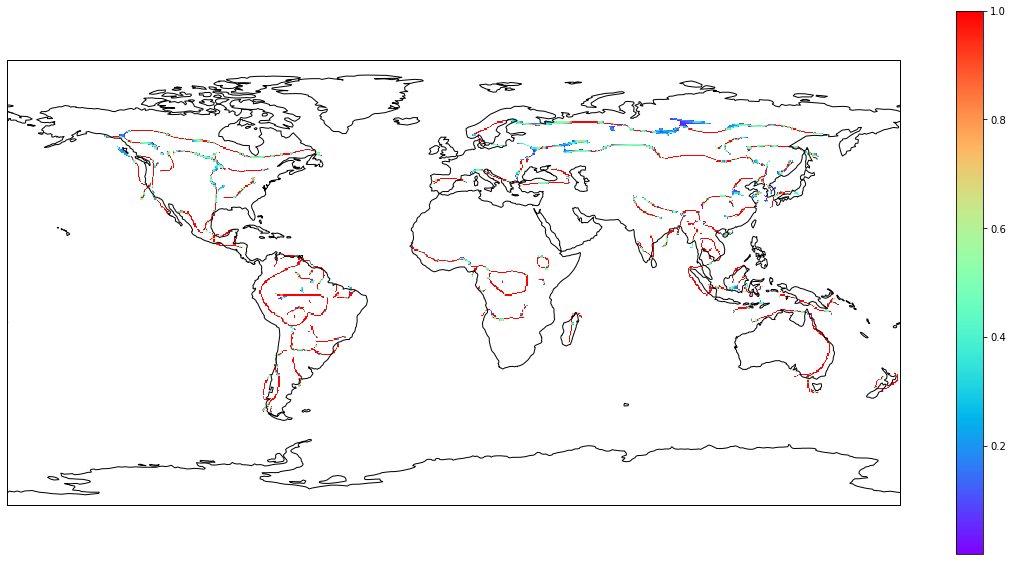

In [36]:
matplotlib.rcParams['figure.figsize'] = (25, 10)
my_cmap = matplotlib.cm.get_cmap('rainbow')
my_cmap.set_under('w')

#plot_plate_carree(box, labels.max(axis=0), cmap=my_cmap, vmin=1)
plot_plate_carree(box, m.sum(axis=0)/m.shape[0], cmap=my_cmap, vmin=0.0001, vmax=1)

In [21]:
fig2=plot_plate_carree(box, m.sum(axis=0)/m.shape[0], cmap=my_cmap, vmin=0.0001, vmax=1)
plt.show()
plt.draw()
fig2.savefig('LAI_obs_edgecount.png',dpi=600)

<Figure size 1800x720 with 0 Axes>